**Importing the libraries:**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


**Uploading the dataset**

In [2]:
from google.colab import files

uploaded = files.upload()

Saving hour.csv to hour (1).csv


**Loading the dataset and viewing the first few rows:**

In [3]:
# Dataset can be downloaded at https://archive.ics.uci.edu/ml/machine-learning-databases/00275/

data = pd.read_csv('hour.csv')

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**Dimensions of the dataset:**

In [4]:
data.shape

(17379, 17)

**Extracting the features:**

In [0]:
# Feature engineering

ohe_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for feature in ohe_features:
  dummies = pd.get_dummies(data[feature], 
                           prefix = feature,
                           drop_first = False)
  data = pd.concat([data, dummies], axis = 1)

drop_features = ['instant', 'dteday', 'season', 'weathersit',
                 'weekday', 'atemp', 'mnth', 'workingday',
                 'hr', 'casual', 'registered']
data = data.drop(drop_features, axis = 1)

**Normalizing the features:**

In [0]:
norm_features = ['cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}

for feature in norm_features:
  mean, std = data[feature].mean(), data[feature].std()
  scaled_features[feature] = [mean, std]
  data.loc[:, feature] = (data[feature] - mean) / std

**Splitting the dataset for training, validation and testing:**

In [0]:
# Save the final month for testing
test_data = data[-31 * 24:]
data = data[:-31 * 24]

# Extract the target field
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

# Create a validation set (based on the last )
X_train, y_train = features[: -30 * 24], targets[: -30 * 24]
X_val, y_val = features[-30 * 24: ], targets[-30 * 24:]

**Viewing the first few rows of the modified dataset:**

In [8]:
data.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.956312,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.823998,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.868103,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.972851,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-1.039008,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Defining the model:**

In [9]:
model = Sequential()

model.add(Dense(250, input_dim = X_train.shape[1],
                activation = 'relu'))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

# Compile model
model.compile(loss = 'mse',
              optimizer = 'sgd',
              metrics = ['mse'])

Instructions for updating:
Colocations handled automatically by placer.


**Setting the hyperparameters and training the model:**

In [10]:
n_epochs = 1000
batch_size = 1024

history = model.fit(X_train.values, y_train['cnt'],
                    validation_data = (X_val.values, y_val['cnt']),
                    batch_size = batch_size,
                    epochs = n_epochs,
                    verbose = 0)

Instructions for updating:
Use tf.cast instead.


**Plotting the training and validation losses:**

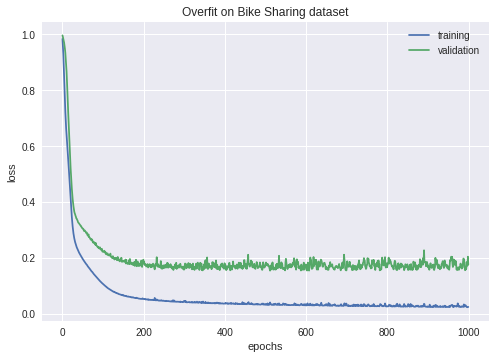

In [17]:
plt.plot(np.arange(len(history.history['loss'])), 
         history.history['loss'],
         label = 'training')

plt.plot(np.arange(len(history.history['val_loss'])),
         history.history['val_loss'],
         label = 'validation')

plt.title('Overfit on Bike Sharing dataset')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 0)
plt.show()

# Model overfits on the training data

**Printing the minimum loss:**

In [12]:
print('Minimum loss: ', min(history.history['val_loss']),
      '\nAfter ', np.argmin(history.history['val_loss']), ' epochs')

Minimum loss:  0.154944509267807 
After  511  epochs


**Adding dropouts to the network architecture to prevent overfitting:**

In [13]:
model_drop = Sequential()

model_drop.add(Dense(250, input_dim = X_train.shape[1],
                     activation = 'relu'))
model_drop.add(Dropout(0.20))
model_drop.add(Dense(150, activation = 'relu'))
model_drop.add(Dropout(0.20))
model_drop.add(Dense(50, activation = 'relu'))
model_drop.add(Dropout(0.20))
model_drop.add(Dense(25, activation = 'relu'))
model_drop.add(Dropout(0.20))
model_drop.add(Dense(1, activation = 'linear'))

# Compile model
model_drop.compile(loss = 'mse',
                   optimizer = 'sgd',
                   metrics = ['mse'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Training the new model:**

In [0]:
history_drop = model_drop.fit(X_train.values, y_train['cnt'],
                              validation_data = (X_val.values, y_val['cnt']),
                              batch_size = batch_size,
                              epochs = n_epochs,
                              verbose = 0)

**Plotting the results:**

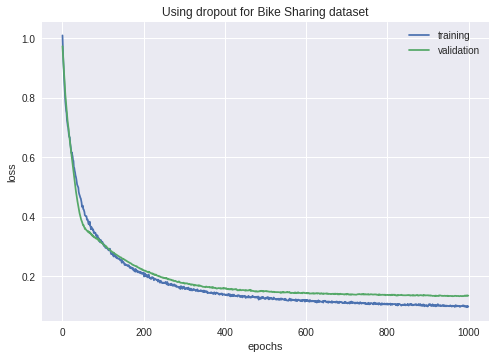

In [15]:
plt.plot(np.arange(len(history_drop.history['loss'])),
         history_drop.history['loss'],
         label = 'training')

plt.plot(np.arange(len(history_drop.history['val_loss'])),
         history_drop.history['val_loss'],
         label = 'validation')

plt.title('Using dropout for Bike Sharing dataset')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 0)
plt.show()

**Printing the statistics:**

In [16]:
print('Minimum loss:', min(history_drop.history['val_loss']),
      '\nAfter ', np.argmin(history_drop.history['val_loss']), ' epochs')

Minimum loss: 0.13367816805839539 
After  960  epochs
